<a href="https://colab.research.google.com/github/IshfaqMalik/Neural_Network/blob/main/Monkey_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks**

In this notebook I built a very basic CNN to cassify monkey breeds. The dataset is downloaded from kaggle & can be found [here](https://https://www.kaggle.com/slothkong/10-monkey-species)






In [2]:
#import libraries
import torch 
import torchvision 
from torchvision import datasets, transforms as T
import torch.nn as nn

In [3]:
import PIL
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
from PIL import Image
from torch.nn import  functional as F
import numpy as np

 In this section, dataset is uploaded and transformed to tensors. Since there is no test set available, I have splited trainset into two (traindata and validation data) and then used validation setr as test set. 


In [5]:
train_transform = T.Compose([T.RandomHorizontalFlip(), T.RandomRotation(10), T.Resize(256),
                       T.CenterCrop(224), T.ToTensor(), T.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])
test_transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])

In [6]:
trainset = datasets.ImageFolder('/content/drive/MyDrive/Monkeys/training/training', transform= train_transform)
testset = datasets.ImageFolder('/content/drive/MyDrive/Monkeys/validation/validation', transform= test_transform)

In [7]:
classes = trainset.classes
classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [8]:
num_workers = 0
# how many samples per batch to load
batch_size = 64
# 20% of training set to use as validation
valid_size = 0.2

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
use_cuda = torch.cuda.is_available()

In [10]:
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#  data loaders (combining dataset and sampler)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
    num_workers=num_workers)

In [11]:
loader = {'train': train_loader,
          'valid': valid_loader,
          'test': test_loader}

Creating CNN Model 

In [12]:
#CNN Architecture

class Convent (nn.Module):
  def __init__(self):
    super(Convent, self).__init__()
    #input shape 64-batch size,3 RGB, 224,224 h & w
    #output filter after Convolutional filter is ((w-f+2p)/s)+1
    self.conv1 = nn.Conv2d(3,32,3, stride =1, padding = 1)
    self.batchnor1 =nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,64,3, stride=1, padding =1)
    self.batchnor2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,128,3, stride=1, padding =1)
    self.batchnor3 = nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128*28*28, 1000)
    self.fc2 = nn.Linear(1000, 100)
    self.fc3 = nn.Linear(100, 10)
    self.dropout = nn.Dropout(p =0.25)

  def forward(self, x):
    x= F.relu(self.batchnor1(self.conv1(x)))
    x = F.relu(self.pool(x))
    x=F.relu(self.batchnor2(self.conv2(x)))
    x=F.relu(self.pool(x))
    x=F.relu(self.batchnor3(self.conv3(x)))
    x=F.relu(self.pool(x))

    #Fprint(x.shape)
    x= x.view(-1, 128*28*28)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=F.relu(self.fc2(x))
    x=self.dropout(x)
    x=F.relu(self.fc3(x))

    return x


In [13]:
#instantiate model 
model_1 = Convent()
# move tensors to GPU if CUDA is available
if use_cuda:
  model_1.cuda()
#checking the architecture
model_1

Convent(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnor1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnor2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnor3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [14]:
def train (n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  """returns trained model"""
  #intializing tracker for minimum validation loss
  min_valid = np.Inf

  
  for epoch in range(1, n_epochs+1):

    #initilizing loss variable

    train_loss =0.0
    valid_loss =0.0
    #############
    #train model
    #############
    
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss = train_loss +((1/(batch_idx+1))*(loss.data - train_loss))
    
    #################
    #model evaluation
    #################
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      
      output = model(data)
      loss = criterion(output, target)
      valid_loss = valid_loss +((1/(batch_idx+1))*(loss.data - valid_loss))
    
    print('Epoch: {} \train_loss {:.6f} \validation_loss {:.6f}' .format(epoch, train_loss, valid_loss))

    if valid_loss <= min_valid:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_valid, valid_loss))
      torch.save(model.state_dict(), save_path)
      min_valid = valid_loss
  
  return model 




Specify Loss Function and Optimizer


In [15]:
# cross entropy loss and SGD Optmizer
criterion_scratch = torch.nn.CrossEntropyLoss()
optimizer_scratch = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum =0.9)

In [16]:
#training and saving model with minimum validation loss 
model_1 = train(15, loader, model_1, optimizer_scratch, criterion_scratch, use_cuda, 'model_1.pt')

Epoch: 1 	rain_loss 2.257672 alidation_loss 2.273715
Validation loss decreased (inf --> 2.273715).  Saving model ...
Epoch: 2 	rain_loss 2.047354 alidation_loss 2.020956
Validation loss decreased (2.273715 --> 2.020956).  Saving model ...
Epoch: 3 	rain_loss 1.791771 alidation_loss 1.669855
Validation loss decreased (2.020956 --> 1.669855).  Saving model ...
Epoch: 4 	rain_loss 1.550868 alidation_loss 1.407726
Validation loss decreased (1.669855 --> 1.407726).  Saving model ...
Epoch: 5 	rain_loss 1.330390 alidation_loss 1.297986
Validation loss decreased (1.407726 --> 1.297986).  Saving model ...
Epoch: 6 	rain_loss 1.238298 alidation_loss 1.266813
Validation loss decreased (1.297986 --> 1.266813).  Saving model ...
Epoch: 7 	rain_loss 1.148712 alidation_loss 1.136610
Validation loss decreased (1.266813 --> 1.136610).  Saving model ...
Epoch: 8 	rain_loss 1.065156 alidation_loss 1.062919
Validation loss decreased (1.136610 --> 1.062919).  Saving model ...
Epoch: 9 	rain_loss 1

In [17]:
# loading trained model 
model_1.load_state_dict(torch.load('model_1.pt'))

<All keys matched successfully>

In [18]:
def test(loaders, model, criterion, use_cuda):
  """ return test accuracy and test loss"""

  test_loss =0.0
  correct = 0.0
  total =0.0

  model.eval()
  for batch_idx, (data, target) in enumerate(loaders['test']):
    if use_cuda:
      data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss = test_loss +((1/(batch_idx +1))*(loss.data - test_loss))
    pred = output.data.max(1, keepdim=True)[1]

    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

  print('Test Loss  {:.6f}'.format(test_loss))

  print('\n Test Accuracy %2d%%  (%2d/%2d)' % (100*correct/total, correct, total))



In [19]:
test(loader, model_1, criterion_scratch, use_cuda)

Test Loss  1.039875

 Test Accuracy 63%  (172/272)


In [20]:
cla_n = {'n0': 'mantled_howler', 'n1': 'patas_monkey', 'n2':'bald_uakari',
       'n3': 'japanese_macaque','n4': 'pygmy_marmoset', 'n5':'white_headed_capuchin',
       'n6': 'silvery_marmoset', 'n7': 'common_squirrel_monkey', 'n8':'black_headed_night_monkey',
       'n9': 'nilgiri_langur'}

In [21]:
labels =[]

for cl in classes:
  labels.append(cla_n[cl])

In [22]:
def monkey_breed(img_path, model):
  img = Image.open(img_path)
  transpose = T.Compose([T.Resize(256), T.CenterCrop(224),
                         T.ToTensor(),
                         T.Normalize(mean =[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]) ])
  tensor_img = transpose(img)[None,:]
  if use_cuda:
    tensor_img = tensor_img.cuda()
    
  
  value, index = torch.max(model(tensor_img),1)
  class_index = index.cpu().numpy()[0]
  plt.imshow(img)
  plt.show()
  return labels[class_index]


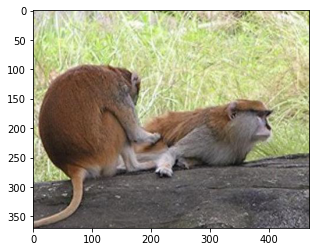

'patas_monkey'

In [24]:
monkey_breed('/content/drive/MyDrive/Monkeys/validation/validation/n1/n100.jpg', model_1)

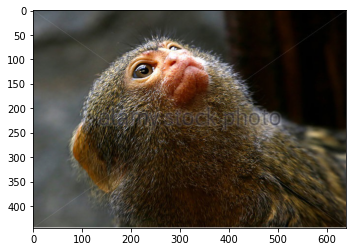

'bald_uakari'

In [25]:
monkey_breed('/content/drive/MyDrive/Monkeys/validation/validation/n4/n400.jpg', model_1)

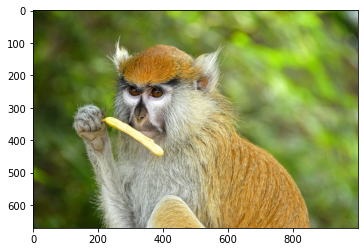

'patas_monkey'

In [26]:
monkey_breed('/content/drive/MyDrive/Monkeys/validation/validation/n1/n101.jpg', model_1)